## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
from keras.layers import BatchNormalization

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "None"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
"""Code Here
建立你的神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024
MOMENTUM = 0.95


In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr = LEARNING_RATE, nesterov = True, momentum = MOMENTUM),
                 keras.optimizers.Adam(lr = LEARNING_RATE),
                 keras.optimizers.RMSprop(lr = LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.4, 0.5, 0.6]
redice_lr_patience = [5, 10]


In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patience) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patience)):
    print("\n", "="*50)
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patience: %i" % (i, reduce_factor, reduce_patience))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor = reduce_factor,
                                  min_lr = 1e-12,
                                  monitor = 'val_loss',
                                  patience = reduce_patience,
                                  verbose = 1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}


Numbers of exp: 0, reduce_factor: 0.40, reduce_patience: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________

50000/50000 [==============================] - 7s 138us/step - loss: 0.8746 - accuracy: 0.7153 - val_loss: 1.4584 - val_accuracy: 0.5014
Epoch 44/50
50000/50000 [==============================] - 7s 140us/step - loss: 0.8746 - accuracy: 0.7160 - val_loss: 1.4586 - val_accuracy: 0.5022

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1.0240000847261399e-05.
Epoch 45/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.8737 - accuracy: 0.7170 - val_loss: 1.4587 - val_accuracy: 0.5018
Epoch 46/50
50000/50000 [==============================] - 7s 139us/step - loss: 0.8739 - accuracy: 0.7153 - val_loss: 1.4587 - val_accuracy: 0.5018
Epoch 47/50
50000/50000 [==============================] - 7s 140us/step - loss: 0.8736 - accuracy: 0.7148 - val_loss: 1.4587 - val_accuracy: 0.5015
Epoch 48/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.8729 - accuracy: 0.7170 - val_loss: 1.4587 - val_accuracy: 0.5022
Epoch 49/50
50000/50000 [===========

Epoch 35/50
50000/50000 [==============================] - 7s 137us/step - loss: 2.3522 - accuracy: 0.2290 - val_loss: 2.3708 - val_accuracy: 0.2237
Epoch 36/50
50000/50000 [==============================] - 7s 137us/step - loss: 2.3521 - accuracy: 0.2285 - val_loss: 2.3699 - val_accuracy: 0.2239
Epoch 37/50
50000/50000 [==============================] - 7s 137us/step - loss: 2.3518 - accuracy: 0.2297 - val_loss: 2.3688 - val_accuracy: 0.2237
Epoch 38/50
50000/50000 [==============================] - 7s 137us/step - loss: 2.3500 - accuracy: 0.2293 - val_loss: 2.3680 - val_accuracy: 0.2241
Epoch 39/50
50000/50000 [==============================] - 7s 138us/step - loss: 2.3489 - accuracy: 0.2296 - val_loss: 2.3671 - val_accuracy: 0.2244
Epoch 40/50
50000/50000 [==============================] - 7s 137us/step - loss: 2.3488 - accuracy: 0.2299 - val_loss: 2.3662 - val_accuracy: 0.2245
Epoch 41/50
50000/50000 [==============================] - 7s 138us/step - loss: 2.3479 - accuracy: 0.2302


Epoch 00026: ReduceLROnPlateau reducing learning rate to 3.2768003865868423e-09.
Epoch 27/50
50000/50000 [==============================] - 7s 138us/step - loss: 3.1173 - accuracy: 0.0933 - val_loss: 3.1241 - val_accuracy: 0.0912
Epoch 28/50
50000/50000 [==============================] - 7s 138us/step - loss: 3.1182 - accuracy: 0.0941 - val_loss: 3.1242 - val_accuracy: 0.0911
Epoch 29/50
50000/50000 [==============================] - 7s 138us/step - loss: 3.1178 - accuracy: 0.0940 - val_loss: 3.1241 - val_accuracy: 0.0912
Epoch 30/50
50000/50000 [==============================] - 7s 138us/step - loss: 3.1172 - accuracy: 0.0939 - val_loss: 3.1240 - val_accuracy: 0.0913
Epoch 31/50
50000/50000 [==============================] - 7s 137us/step - loss: 3.1164 - accuracy: 0.0938 - val_loss: 3.1242 - val_accuracy: 0.0912

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.6384001932934211e-09.
Epoch 32/50
50000/50000 [==============================] - 7s 137us/step - loss: 3.1181 - a

50000/50000 [==============================] - 7s 136us/step - loss: 3.0342 - accuracy: 0.0985 - val_loss: 2.9974 - val_accuracy: 0.1006
Epoch 19/50
50000/50000 [==============================] - 7s 141us/step - loss: 3.0354 - accuracy: 0.0980 - val_loss: 3.0002 - val_accuracy: 0.1008
Epoch 20/50
50000/50000 [==============================] - 7s 144us/step - loss: 3.0345 - accuracy: 0.0971 - val_loss: 3.0019 - val_accuracy: 0.1009
Epoch 21/50
50000/50000 [==============================] - 7s 139us/step - loss: 3.0354 - accuracy: 0.0973 - val_loss: 3.0030 - val_accuracy: 0.1009

Epoch 00021: ReduceLROnPlateau reducing learning rate to 5.120000604041941e-11.
Epoch 22/50
50000/50000 [==============================] - 7s 137us/step - loss: 3.0340 - accuracy: 0.0979 - val_loss: 3.0038 - val_accuracy: 0.1007
Epoch 23/50
50000/50000 [==============================] - 7s 138us/step - loss: 3.0346 - accuracy: 0.0968 - val_loss: 3.0044 - val_accuracy: 0.1008
Epoch 24/50
50000/50000 [============

50000/50000 [==============================] - 7s 141us/step - loss: 3.0032 - accuracy: 0.1088 - val_loss: 2.8199 - val_accuracy: 0.1124
Epoch 11/50
50000/50000 [==============================] - 7s 143us/step - loss: 3.0029 - accuracy: 0.1089 - val_loss: 2.8633 - val_accuracy: 0.1116

Epoch 00011: ReduceLROnPlateau reducing learning rate to 4.608000439554338e-12.
Epoch 12/50
50000/50000 [==============================] - 7s 139us/step - loss: 3.0040 - accuracy: 0.1078 - val_loss: 2.9008 - val_accuracy: 0.1107
Epoch 13/50
50000/50000 [==============================] - 7s 140us/step - loss: 3.0028 - accuracy: 0.1082 - val_loss: 2.9311 - val_accuracy: 0.1101
Epoch 14/50
50000/50000 [==============================] - 7s 140us/step - loss: 3.0040 - accuracy: 0.1082 - val_loss: 2.9547 - val_accuracy: 0.1100
Epoch 15/50
50000/50000 [==============================] - 7s 142us/step - loss: 3.0035 - accuracy: 0.1084 - val_loss: 2.9725 - val_accuracy: 0.1104
Epoch 16/50
50000/50000 [============

50000/50000 [==============================] - 7s 140us/step - loss: 3.0169 - accuracy: 0.0966 - val_loss: 2.3519 - val_accuracy: 0.1138
Epoch 3/50
50000/50000 [==============================] - 8s 151us/step - loss: 3.0175 - accuracy: 0.0973 - val_loss: 2.4169 - val_accuracy: 0.1070
Epoch 4/50
50000/50000 [==============================] - 8s 151us/step - loss: 3.0165 - accuracy: 0.0967 - val_loss: 2.4836 - val_accuracy: 0.1020
Epoch 5/50
50000/50000 [==============================] - 7s 149us/step - loss: 3.0159 - accuracy: 0.0964 - val_loss: 2.5495 - val_accuracy: 0.1009
Epoch 6/50
50000/50000 [==============================] - 7s 143us/step - loss: 3.0157 - accuracy: 0.0969 - val_loss: 2.6152 - val_accuracy: 0.0998
Epoch 7/50
50000/50000 [==============================] - 7s 147us/step - loss: 3.0160 - accuracy: 0.0974 - val_loss: 2.6792 - val_accuracy: 0.0986
Epoch 8/50
50000/50000 [==============================] - 7s 143us/step - loss: 3.0159 - accuracy: 0.0976 - val_loss: 2.739

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.7729 - accuracy: 0.3841 - val_loss: 2.5324 - val_accuracy: 0.1931
Epoch 2/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.5005 - accuracy: 0.4704 - val_loss: 1.8987 - val_accuracy: 0.3247
Epoch 3/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.3968 - accuracy: 0.5078 - val_loss: 2.0233 - val_accuracy: 0.2881
Epoch 4/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.3181 - accuracy: 0.5371 - val_loss: 1.7685 - val_accuracy: 0.3660
Epoch 5/50
50000/50000 [==============================] - 7s 150us/step - loss: 1.2510 - accuracy: 0.5593 - val_loss: 1.6359 - val_accuracy: 0.4146
Epoch 6/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.1974 - accuracy: 0.5773 - val_loss: 1.9750 - val_accuracy: 0.3378
Epoch 7/50
50000/50000 [==============================] - 8s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 168us/step - loss: 2.5984 - accuracy: 0.1699 - val_loss: 2.2435 - val_accuracy: 0.1600
Epoch 2/50
50000/50000 [==============================] - 7s 149us/step - loss: 2.2555 - accuracy: 0.2460 - val_loss: 2.1674 - val_accuracy: 0.2311
Epoch 3/50
50000/50000 [==============================] - 8s 152us/step - loss: 2.1326 - accuracy: 0.2779 - val_loss: 2.0946 - val_accuracy: 0.2609
Epoch 4/50
50000/50000 [==============================] - 7s 149us/step - loss: 2.0619 - accuracy: 0.2980 - val_loss: 2.0285 - val_accuracy: 0.2840
Epoch 5/50
50000/50000 [==============================] - 7s 148us/step - loss: 2.0116 - accuracy: 0.3121 - val_loss: 1.9779 - val_accuracy: 0.3048
Epoch 6/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.9735 - accuracy: 0.3229 - val_loss: 1.9389 - val_accuracy: 0.3184
Epoch 7/50
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 162us/step - loss: 2.6093 - accuracy: 0.1783 - val_loss: 2.2649 - val_accuracy: 0.1456
Epoch 2/50
50000/50000 [==============================] - 7s 150us/step - loss: 2.2767 - accuracy: 0.2499 - val_loss: 2.2161 - val_accuracy: 0.1973
Epoch 3/50
50000/50000 [==============================] - 7s 148us/step - loss: 2.1593 - accuracy: 0.2788 - val_loss: 2.1726 - val_accuracy: 0.2248
Epoch 4/50
50000/50000 [==============================] - 7s 148us/step - loss: 2.0878 - accuracy: 0.2968 - val_loss: 2.1140 - val_accuracy: 0.2485
Epoch 5/50
50000/50000 [==============================] - 7s 148us/step - loss: 2.0365 - accuracy: 0.3106 - val_loss: 2.0466 - val_accuracy: 0.2745
Epoch 6/50
50000/50000 [==============================] - 8s 150us/step - loss: 1.9964 - accuracy: 0.3215 - val_loss: 1.9922 - val_accuracy: 0.2959
Epoch 7/50
50000/50000 [==============================] - 7s 1

_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 160us/step - loss: 2.5335 - accuracy: 0.1852 - val_loss: 2.2386 - val_accuracy: 0.1522
Epoch 2/50
50000/50000 [==============================] - 7s 148us/step - loss: 2.2143 - accuracy: 0.2621 - val_loss: 2.1679 - val_accuracy: 0.2114
Epoch 3/50
50000/50000 [==============================] - 8s 151us/step - loss: 2.1072 - accuracy: 0.2885 - val_loss: 2.1070 - val_accuracy: 0.2377
Epoch 4/50
50000/50000 [==============================] - 7s 149us/step - loss: 2.0421 - accuracy: 0.3062 - val_loss: 2.0454 - val_accuracy: 0.2637
Epoch 5/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.9947 - accuracy: 0.3196 - val_loss: 1.9936 - val_accuracy: 0.2884
Epoch 6/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.9597 - accuracy: 0.3295 - val_loss: 1.9527 - val_accuracy: 0.3

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 164us/step - loss: 2.6058 - accuracy: 0.1823 - val_loss: 2.2349 - val_accuracy: 0.1512
Epoch 2/50
50000/50000 [==============================] - 8s 150us/step - loss: 2.2526 - accuracy: 0.2595 - val_loss: 2.1754 - val_accuracy: 0.2011
Epoch 3/50
50000/50000 [==============================] - 8s 151us/step - loss: 2.1363 - accuracy: 0.2857 - val_loss: 2.1180 - val_accuracy: 0.2353
Epoch 4/50
50000/50000 [==============================] - 8s 151us/step - loss: 2.0693 - accuracy: 0.3018 - val_loss: 2.0588 - val_accuracy: 0.2615
Epoch 5/50
50000/50000 [==============================] - 8s 152us/step - loss: 2.0223 - accuracy: 0.3131 - val_loss: 2.0034 - val_accuracy: 0.2827
Epoch 6/50
50000/50000 [==============================] - 8s 151us/step - loss: 1.9860 - accuracy: 0.3233 - val_loss: 1.9616 - val_accuracy: 0.3050
Epoch 7/50
50000/50000 [==============================] - 8s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 163us/step - loss: 2.5841 - accuracy: 0.1838 - val_loss: 2.1965 - val_accuracy: 0.2159
Epoch 2/50
50000/50000 [==============================] - 8s 152us/step - loss: 2.2373 - accuracy: 0.2562 - val_loss: 2.1335 - val_accuracy: 0.2405
Epoch 3/50
50000/50000 [==============================] - 8s 151us/step - loss: 2.1212 - accuracy: 0.2883 - val_loss: 2.0988 - val_accuracy: 0.2560
Epoch 4/50
50000/50000 [==============================] - 8s 151us/step - loss: 2.0558 - accuracy: 0.3049 - val_loss: 2.0573 - val_accuracy: 0.2752
Epoch 5/50
50000/50000 [==============================] - 8s 152us/step - loss: 2.0087 - accuracy: 0.3162 - val_loss: 2.0074 - val_accuracy: 0.2931
Epoch 6/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.9724 - accuracy: 0.3282 - val_loss: 1.9657 - val_accuracy: 0.3095
Epoch 7/50
50000/50000 [==============================] - 8s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.8281 - accuracy: 0.3693 - val_loss: 2.3339 - val_accuracy: 0.2313
Epoch 2/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.5453 - accuracy: 0.4549 - val_loss: 2.3394 - val_accuracy: 0.2268
Epoch 3/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.4385 - accuracy: 0.4930 - val_loss: 2.0706 - val_accuracy: 0.3181
Epoch 4/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.3604 - accuracy: 0.5181 - val_loss: 2.0464 - val_accuracy: 0.3184
Epoch 5/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.3009 - accuracy: 0.5398 - val_loss: 2.0577 - val_accuracy: 0.3224
Epoch 6/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.2452 - accuracy: 0.5627 - val_loss: 2.2186 - val_accuracy: 0.2966
Epoch 7/50
50000/50000 [==============================] - 7s 1

Total params: 1,742,474
Trainable params: 1,740,682
Non-trainable params: 1,792
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 158us/step - loss: 3.0207 - accuracy: 0.0913 - val_loss: 2.3399 - val_accuracy: 0.0861
Epoch 2/50
50000/50000 [==============================] - 8s 153us/step - loss: 2.8119 - accuracy: 0.1202 - val_loss: 2.3288 - val_accuracy: 0.1435
Epoch 3/50
50000/50000 [==============================] - 7s 148us/step - loss: 2.6597 - accuracy: 0.1483 - val_loss: 2.3142 - val_accuracy: 0.1748
Epoch 4/50
50000/50000 [==============================] - 7s 146us/step - loss: 2.5417 - accuracy: 0.1746 - val_loss: 2.2856 - val_accuracy: 0.1947
Epoch 5/50
50000/50000 [==============================] - 7s 147us/step - loss: 2.4464 - accuracy: 0.1963 - val_loss: 2.2467 - val_accuracy: 0.2110
Epoch 6/50
50000/50000 [==============================] - 7s 146

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 154us/step - loss: 2.8981 - accuracy: 0.1155 - val_loss: 2.3113 - val_accuracy: 0.1339
Epoch 2/50
50000/50000 [==============================] - 7s 143us/step - loss: 2.7273 - accuracy: 0.1453 - val_loss: 2.2916 - val_accuracy: 0.1594
Epoch 3/50
50000/50000 [==============================] - 7s 143us/step - loss: 2.6018 - accuracy: 0.1714 - val_loss: 2.2774 - val_accuracy: 0.1829
Epoch 4/50
50000/50000 [==============================] - 7s 143us/step - loss: 2.5055 - accuracy: 0.1942 - val_loss: 2.2553 - val_accuracy: 0.1970
Epoch 5/50
50000/50000 [==============================] - 7s 144us/step - loss: 2.4262 - accuracy: 0.2114 - val_loss: 2.2293 - val_accuracy: 0.2147
Epoch 6/50
50000/50000 [==============================] - 7s 143us/step - loss: 2.3606 - accuracy: 0.2273 - val_loss: 2.2032 - val_accuracy: 0.2302
Epoch 7/50
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 158us/step - loss: 2.9365 - accuracy: 0.1156 - val_loss: 2.3197 - val_accuracy: 0.1259
Epoch 2/50
50000/50000 [==============================] - 7s 147us/step - loss: 2.7758 - accuracy: 0.1427 - val_loss: 2.3087 - val_accuracy: 0.1465
Epoch 3/50
50000/50000 [==============================] - 7s 146us/step - loss: 2.6526 - accuracy: 0.1667 - val_loss: 2.2840 - val_accuracy: 0.1714
Epoch 4/50
50000/50000 [==============================] - 7s 146us/step - loss: 2.5513 - accuracy: 0.1864 - val_loss: 2.2516 - val_accuracy: 0.1896
Epoch 5/50
50000/50000 [==============================] - 7s 145us/step - loss: 2.4669 - accuracy: 0.2052 - val_loss: 2.2163 - val_accuracy: 0.2107
Epoch 6/50
50000/50000 [==============================] - 7s 145us/step - loss: 2.3961 - accuracy: 0.2202 - val_loss: 2.1888 - val_accuracy: 0.2272
Epoch 7/50
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 161us/step - loss: 2.9680 - accuracy: 0.0964 - val_loss: 2.3434 - val_accuracy: 0.0964
Epoch 2/50
50000/50000 [==============================] - 7s 149us/step - loss: 2.7763 - accuracy: 0.1282 - val_loss: 2.3266 - val_accuracy: 0.1160
Epoch 3/50
50000/50000 [==============================] - 7s 148us/step - loss: 2.6364 - accuracy: 0.1611 - val_loss: 2.3000 - val_accuracy: 0.1529
Epoch 4/50
50000/50000 [==============================] - 8s 151us/step - loss: 2.5313 - accuracy: 0.1891 - val_loss: 2.2652 - val_accuracy: 0.1850
Epoch 5/50
50000/50000 [==============================] - 8s 162us/step - loss: 2.4460 - accuracy: 0.2083 - val_loss: 2.2279 - val_accuracy: 0.2097
Epoch 6/50
50000/50000 [==============================] - 8s 152us/step - loss: 2.3779 - accuracy: 0.2263 - val_loss: 2.1925 - val_accuracy: 0.2283
Epoch 7/50
50000/50000 [==============================] - 8s 1

_________________________________________________________________
batch_normalization_53 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_54 (Batc (None, 128)               512       
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,742,474
Trainable params: 1,740,682
Non-trainable params: 1,792
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 166us/step - loss: 2.8036 - accuracy: 0.1358 - val_loss: 2.3012 - val_accuracy: 0.1249
Epoch 2/50
50000/50000 [==============================] - 8s 159us/step - loss: 2.6449 - accuracy: 0.1628 - val_loss: 2.2479 - v

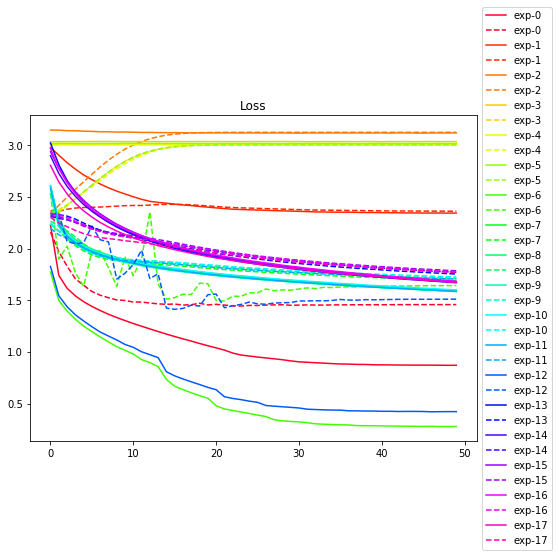

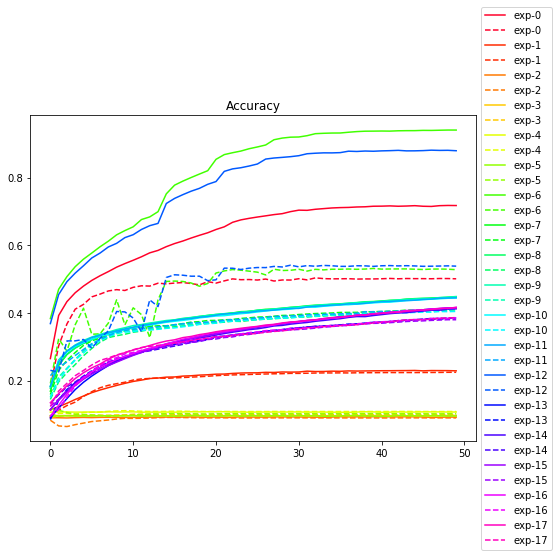

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()